# End‑to‑End Time‑Series Modeling: LightGBM & XGBoost on Multi‑Ticker EOD Data

**Files expected in this folder:**
- `Interview.parquet` – training/validation period
- `Interview_info.parquet` – column metadata
- `Interview_test.parquet` – testing period

This notebook:
1. Cleans and prepares the data for time‑series analysis.
2. Proposes a **grouping method** for tickers via KMeans using mean price, volatility and mean volume.
3. Engineers features (lags, rolling stats, RSI, log_return, volatility, roc, vwap etc).
4. Trains **LightGBM** and **XGBoost for every ticker** (or restricted to a selected subgroup).
5. Evaluates on a time‑based validation split and on the provided test set.

> **Assumptions**
> - No target leakage: we only use historical data to predict **next‑day close** (you can switch to `volume` or others).
> - We avoid time‑series *statistical* model packages for modeling (OK for analysis), and use ML packages (LightGBM, XGBoost).


# 1. Load and check the Datasets

In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import torch
# import torch.nn as nn from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Reading all the datasets
info = pd.read_parquet('Interview_info.parquet', engine="pyarrow")
train = pd.read_parquet('Interview.parquet', engine="pyarrow")
test = pd.read_parquet('Interview_test.parquet', engine="pyarrow")

In [2]:
# View the info first
info

,indicator,title,description,unittype
0,open,Open Price - Split Adjusted,The official exchange opening price; adjusted ...,USD/share
1,ticker,Ticker Symbol,Anonymized ticker symbol.The ticker is a uniqu...,text
2,date,Price Date,The trade date of the price observations.,date (YYYY-MM-DD)
3,high,High Price - Split Adjusted,The high share price; adjusted for stock split...,USD/share
4,low,Low Price - Split Adjusted,The low share price; adjusted for stock splits...,USD/share
5,close,Close Price - Split Adjusted,The official exchange close price; adjusted fo...,USD/share
6,volume,Volume - Split Adjusted,The daily traded volume across all exchanges; ...,numeric
7,closeadj,Close Price - Adjusted for Splits Dividends an...,The official exchange close price; adjusted fo...,USD/share
8,closeunadj,Close Price - Unadjusted,The official exchange close price; not adjuste...,USD/share


In [3]:
# View the top 5 rows on train
train.head()

,date,open,high,low,close,volume,closeadj,closeunadj,ticker
0,2024-01-30,18.80,18.87,18.67,18.77,44712.0,18.77,18.77,EkEuXFUQrK
1,2024-04-04,20.02,20.22,20.02,20.22,17117.0,20.22,20.22,EkEuXFUQrK
2,2024-04-04,10.24,10.24,10.24,10.24,973.0,10.24,10.24,ZL4m1dXqNc
3,2024-04-03,10.30,10.30,10.30,10.30,0.0,10.30,10.30,ZL4m1dXqNc
4,2024-04-04,180.20,184.43,179.75,181.57,945184.0,181.57,181.57,31cWpkAP9J


In [4]:
# View the top 5 rows on test
test.head()

,date,open,high,low,close,volume,closeadj,closeunadj,ticker
0,2024-07-05,10.700,10.70,10.700,10.700,0.0,10.700,10.700,Ge5UaJiX8z
1,2024-07-08,20.200,20.35,20.100,20.250,12885.0,20.250,20.250,EkEuXFUQrK
2,2024-07-08,10.370,10.37,10.370,10.370,1709.0,10.370,10.370,ZL4m1dXqNc
3,2024-07-05,10.360,10.36,10.360,10.360,0.0,10.360,10.360,ZL4m1dXqNc
4,2024-07-08,0.033,0.04,0.027,0.027,32062.0,0.027,0.027,yvwY3aznZx


# 3. Data Cleaning and Grouping method (Kmeans)
This Section:
1. Cleans and prepares the data for time‑series analysis.
2. Proposes a **grouping method** for tickers via KMeans using mean price, volatility and mean volume.
3. Applies grouping method to the test dataset 
4. Selection of a grouping for further processes

In [5]:
# Check for NaN
na_summary = pd.concat([train.isna().sum().rename('train'), test.isna().sum().rename('test')], axis=1)
na_summary

,train,test
date,0,0
open,0,0
high,0,0
low,0,0
close,0,0
volume,0,0
closeadj,0,0
closeunadj,0,0
ticker,0,0


In [6]:
# Sorts the dataset to make sure that it all tickers are together, sorted by the date
train = train.sort_values(['ticker', 'date']).reset_index(drop=True)
test = test.sort_values(['ticker', 'date']).reset_index(drop=True)

df_train = train.groupby('ticker').agg({'close': ['mean', 'std'], # mean price, volatility
                                                    'volume': 'mean'})
df_test = test.groupby('ticker').agg({'close': ['mean', 'std'], # mean price, volatility
                                                  'volume': 'mean'})
df_train.columns = ['_'.join(col) for col in df_train.columns]
df_test.columns = ['_'.join(col) for col in df_test.columns]
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train)
X_test_scaled = scaler.transform(df_test)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
df_train['cluster'] = kmeans.fit_predict(X_train_scaled)
df_test['cluster'] = kmeans.predict(X_test_scaled)
df_train['cluster'].value_counts()

cluster
9    5710
0    1088
5     310
6      89
3      21
8      16
4       7
7       2
1       1
2       1
Name: count, dtype: int64

In [7]:
# Cluster 0 used as main subgroup
tickers_in_cluster_0 = list(df_train[df_train['cluster'] == 0].index)
df_train = train[train['ticker'].isin(tickers_in_cluster_0)]
df_test = test[test['ticker'].isin(tickers_in_cluster_0)]

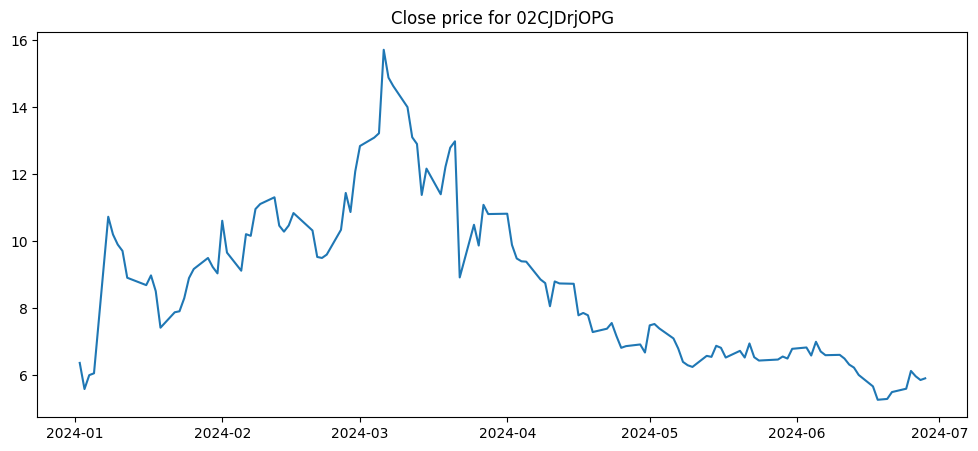

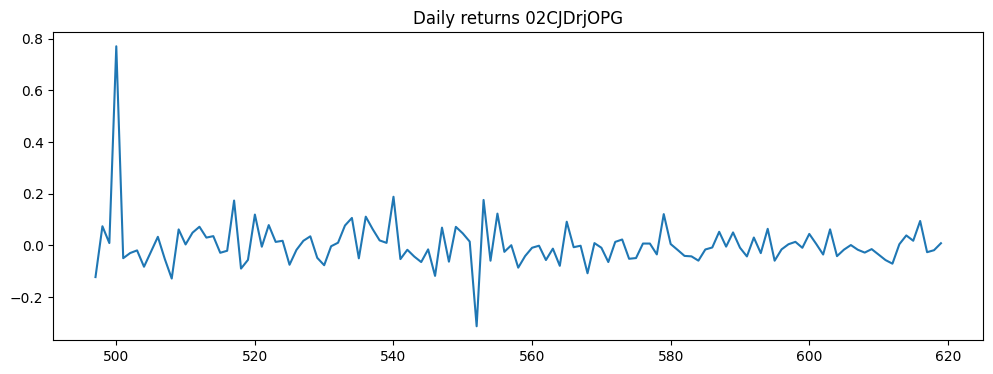

In [8]:
# Plot example ticker
example = df_train[df_train['ticker'] == df_train['ticker'].unique()[0]]

plt.figure(figsize=(12,5))
plt.plot(example['date'], example['close'])
plt.title(f"Close price for {example['ticker'].iloc[0]}")
plt.show()

# Volatility example
returns = example['close'].pct_change()
returns.plot(figsize=(12,4), title=f"Daily returns {example['ticker'].iloc[0]}")
plt.show()

# 4. Feature Engineering
Returns:
- Daily arithmetic return (pct_change)
- Log return (log1p)

Volume Weighted Average Price (VWAP):
- Typical price = (high + low + close) / 3
- Cumulative VWAP = weighted average of typical price by volume

Moving Averages (trend indicators):
- Simple MA with windows 5, 10, 20
- Exponential MA (EMA12, EMA26)

Volatility (risk proxy):
- Rolling standard deviation of returns with windows 5, 10, 20

Momentum:
- Rate of change (ROC) of close over 5 and 10 days

Relative Strength Index (RSI14):
- Based on 14-day rolling avg gains vs losses

Lagged Features (autoregressive signals):
- Close and volume shifted by 1, 2, 3, 5, 10 days


In [9]:
def add_features(df_ticker):
    df_ticker = df_ticker.copy()
    
    # Returns
    df_ticker['return'] = df_ticker['close'].pct_change()
    df_ticker['log_return'] = np.log1p(df_ticker['return'])
    
    # VWAP (Volume Weighted Average Price)
    # Typical price = (high + low + close) / 3
    df_ticker['typical_price'] = (df_ticker['high'] + df_ticker['low'] + df_ticker['close']) / 3
    df_ticker['vwap'] = (df_ticker['typical_price'] * df_ticker['volume']).cumsum() / df_ticker['volume'].cumsum()
    
    # Moving Averages
    df_ticker['ma5'] = df_ticker['close'].rolling(5).mean()
    df_ticker['ma10'] = df_ticker['close'].rolling(10).mean()
    df_ticker['ma20'] = df_ticker['close'].rolling(20).mean()
    
    # Exponential Moving Average (EMA)
    df_ticker['ema12'] = df_ticker['close'].ewm(span=12, adjust=False).mean()
    df_ticker['ema26'] = df_ticker['close'].ewm(span=26, adjust=False).mean()
    
    # Rolling Volatility
    df_ticker['volatility_5'] = df_ticker['return'].rolling(5).std()
    df_ticker['volatility_10'] = df_ticker['return'].rolling(10).std()
    df_ticker['volatility_20'] = df_ticker['return'].rolling(20).std()
    
    # Momentum
    df_ticker['roc_5'] = df_ticker['close'].pct_change(5)
    df_ticker['roc_10'] = df_ticker['close'].pct_change(10)
    
    # Relative Strength Index (RSI)
    delta = df_ticker['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gain).rolling(14).mean()
    roll_down = pd.Series(loss).rolling(14).mean()
    rs = roll_up / roll_down
    df_ticker['rsi14'] = 100.0 - (100.0 / (1.0 + rs))
    
    # Lag features
    for lag in [1, 2, 3, 5, 10]:
        df_ticker[f'close_lag{lag}'] = df_ticker['close'].shift(lag)
        df_ticker[f'volume_lag{lag}'] = df_ticker['volume'].shift(lag)
    
    return df_ticker

# Adding the same features to both train and test
df_features_train = df_train.groupby('ticker', group_keys=False).apply(add_features)
df_features_test = df_test.groupby('ticker', group_keys=False).apply(add_features)

In [10]:
# View the top 5 rows in train after feature engineering
df_features_train.head()

,date,open,high,low,close,volume,closeadj,closeunadj,ticker,return,...,close_lag1,volume_lag1,close_lag2,volume_lag2,close_lag3,volume_lag3,close_lag5,volume_lag5,close_lag10,volume_lag10
496,2024-01-02,6.41,7.05,6.052,6.370,1671524.0,6.370,6.370,02CJDrjOPG,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,2024-01-03,6.22,6.24,5.372,5.590,2010267.0,5.590,5.590,02CJDrjOPG,-0.122449,...,6.370,1671524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,2024-01-04,5.63,6.28,5.500,6.005,1189989.0,6.005,6.005,02CJDrjOPG,0.074240,...,5.590,2010267.0,6.370,1671524.0,NaN,NaN,NaN,NaN,NaN,NaN
499,2024-01-05,5.95,6.16,5.530,6.060,1256734.0,6.060,6.060,02CJDrjOPG,0.009159,...,6.005,1189989.0,5.590,2010267.0,6.37,1671524.0,NaN,NaN,NaN,NaN
500,2024-01-08,5.99,11.23,5.900,10.730,45918740.0,10.730,10.730,02CJDrjOPG,0.770627,...,6.060,1256734.0,6.005,1189989.0,5.59,2010267.0,NaN,NaN,NaN,NaN


In [11]:
# View the top 5 rows in test after feature engineering
df_features_test.head()

,date,open,high,low,close,volume,closeadj,closeunadj,ticker,return,...,close_lag1,volume_lag1,close_lag2,volume_lag2,close_lag3,volume_lag3,close_lag5,volume_lag5,close_lag10,volume_lag10
80,2024-07-02,5.78,5.890,5.245,5.260,564327.0,5.260,5.260,02CJDrjOPG,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,2024-07-03,5.26,5.587,5.140,5.355,232396.0,5.355,5.355,02CJDrjOPG,0.018061,...,5.260,564327.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,2024-07-05,5.33,5.340,5.115,5.180,361695.0,5.180,5.180,02CJDrjOPG,-0.032680,...,5.355,232396.0,5.260,564327.0,NaN,NaN,NaN,NaN,NaN,NaN
83,2024-07-08,5.27,5.480,5.160,5.300,565899.0,5.300,5.300,02CJDrjOPG,0.023166,...,5.180,361695.0,5.355,232396.0,5.260,564327.0,NaN,NaN,NaN,NaN
84,2024-07-09,5.28,5.730,5.160,5.720,622595.0,5.720,5.720,02CJDrjOPG,0.079245,...,5.300,565899.0,5.180,361695.0,5.355,232396.0,NaN,NaN,NaN,NaN


# 5. Time-Series with LightGBM

In [12]:
# Encode ticker
df_features_train['ticker_id'] = df_features_train['ticker'].astype('category').cat.codes
df_features_test['ticker_id']  = df_features_test['ticker'].astype('category').cat.codes

# Features & target
feature_cols = ['close_lag1','close_lag2','close_lag3','close_lag5','close_lag10',
                'volume_lag1','volume_lag2','volume_lag3','ma5','ma10','ma20',
                'ema12','ema26','volatility_5','volatility_10','volatility_20',
                'roc_5','roc_10','rsi14','vwap','ticker_id']

X_train, y_train = df_features_train[feature_cols], df_features_train['close']
X_test, y_test   = df_features_test[feature_cols],  df_features_test['close']

# Train LightGBM
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=['ticker_id'])

params = {'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.03,
          'num_leaves': 63,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'random_state': 42,
          'n_jobs': -1, 
          'verbose': -1}

model_lgb = lgb.train(params, lgb_train, num_boost_round=500)

# Predictions
preds_lgb_test = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
df_features_test['lightGBM_pred'] = preds_lgb_test

# Evaluation
lgb_rmse = mean_squared_error(y_test, preds_lgb_test)
lgb_mae  = mean_absolute_error(y_test, preds_lgb_test)

with open("LightGBM.pkl", "wb") as f:
    pickle.dump(model_lgb, f)

# 6. Time-Series with XGBoost

In [13]:
# Train XGBoost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             learning_rate=0.03,
                             n_estimators=500,
                             max_depth=6, 
                             subsample=0.8,
                             colsample_bytree=0.8,
                             random_state=42,
                             n_jobs=-1)

model_xgb.fit(X_train, y_train)

# Predictions
preds_xgb_test = model_xgb.predict(X_test)
df_features_test['XGB_pred'] = preds_xgb_test

# Evaluation
xgb_rmse = mean_squared_error(y_test, preds_xgb_test)
xgb_mae  = mean_absolute_error(y_test, preds_xgb_test)

with open("XGBoost.pkl", "wb") as f:
    pickle.dump(model_xgb, f)

# Comparison

In [14]:
def evaluate_models(df):
    results = []
    for ticker, df_grp in df.groupby('ticker'):
        y_true = df_grp['close']
        y_pred_lgb = df_grp['lightGBM_pred']
        y_pred_xgb = df_grp['XGB_pred']

        results.append({'ticker': ticker,
                        'lgb_rmse': np.sqrt(mean_squared_error(y_true, y_pred_lgb)),
                        'xgb_rmse': np.sqrt(mean_squared_error(y_true, y_pred_xgb)),
                        'lgb_mae': mean_absolute_error(y_true, y_pred_lgb),
                        'xgb_mae': mean_absolute_error(y_true, y_pred_xgb)})
    return pd.DataFrame(results)

df_eval = evaluate_models(df_features_test[['ticker','close','lightGBM_pred','XGB_pred']])
print(f"LightGBM RMSE: {lgb_rmse:.4f}")
print(f"XGBoost RMSE: {xgb_rmse:.4f}\n")

print(f"LightGBM MAE: {lgb_mae:.4f}")
print(f"XGBoost MAE: {xgb_mae:.4f}")

df_eval

LightGBM RMSE: 261.2634
XGBoost RMSE: 151.7850

LightGBM MAE: 1.9168
XGBoost MAE: 1.5228


,ticker,lgb_rmse,xgb_rmse,lgb_mae,xgb_mae
0,02CJDrjOPG,0.336917,0.402109,0.263567,0.301405
1,05gj77duN2,1.190234,1.245611,0.840431,0.845834
2,08cAmXR8Dh,0.186710,0.171710,0.134153,0.139883
3,09KIlY85uZ,0.178506,0.169651,0.143271,0.124180
4,0Hw9RH7EtD,0.158514,0.342832,0.129112,0.161644
...,...,...,...,...,...
1040,zkD88pjACe,1.408882,1.451033,1.010775,0.992108
1041,zkIrp2N4H9,1.018479,1.246777,0.780901,0.894807
1042,zkhvylJpde,4.590113,4.853716,3.607223,3.473907
1043,zmu5fxWn4o,1.984022,0.301138,1.623701,0.232054


#### From the results above, XGBoost performs slightly better than LightGBM